# Visualizing COVID-19 Data at the State and County Levels in Python
## Part I: Downloading and Organizing Data

From casual observation, I surmise that the widespread stay-at-home orders initiated in March 2020 have left data scientists with a bit of extra time as, with each passing week, I find new sources for COVID-19 data and data visualizations. I have written before about the [proper](https://www.ndsu.edu/centers/pcpe/news/detail/58432/) and [improper](https://www.aier.org/article/visualizations-are-powerful-but-often-misleading/) uses of data. In this post, my purpose is pedagogical. I intend to teach the reader how to download and organize COVID-19 data and how to honestly and meaningfully visualize this data.

First, a confession. I am a self-taught programmer. Like many of us, much of what I write can be described as *spaghetti code*, at least initially. I don't thoroughly plan a program before I write it. I roll up my sleeves and get to coding. This has its benefits. Rarely is the perfect the enemy of the good when I first construct a program. Since I'm not writing my code for commercial use, I am able to efficiently produce results. 

One benefit of building code on the fly is that you may not know at the start of a project what sorts of qualities will be useful to include. As with all creative processes, _discovery_ is often a process that is dependent upon context that emerges from the process of development. _Spaghetti code_ can also be swiftly repurposed, usually by creation  of a new copy of the script and making some marginal adjustments. However, the more spaghetti code you write for a particular project and the more kinds of output demanded by the project, the greater the difficulty of maintaining quality code that is easy to read. At some point, you've got to standardize components of your code. 

When I find myself returning time and again to a particular template, I eventually consolidate the scripts that I have developed so as to minimize costs of editing code by modularizing the code. Standardizing different blocks of code by creating and implementing functions allows the script to produce a variety of outputs. The script in this example that is in the middle stages of this process of development, revision, and standardization.

Much of the information concerning how the program works is included as notes in the code. These notes are preceded by the _#_ symbol.

### Downloading the COVID-19 data

We will use two datasets. First, we will import a shapefile to use with *geopandas*, which we will later use to generate a county level map that tracks COVID-19. The shapefile is provide for you in the Github folder housing this post. You can also download shapefiles from the U.S. Census [website](https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html). We will create maps in [Part III](https://github.com/jlcatonjr/Learn-Python-for-Stats-and-Econ/blob/master/Projects/COVID19/Visualizing%20COVID-19%20Data%20at%20the%20State%20and%20County%20Levels%20in%20Python%20-%20Part%20III.ipynb). We will download Johns Hopkins's COVID-19 data from the Associated Press's [account](https://data.world/associatedpress/johns-hopkins-coronavirus-case-tracker) at data.world using their [Python module](https://data.world/integrations/python). Follow [these instructions](https://github.com/datadotworld/data.world-py/) to install the  *datadotworld* module and access their API.

Once we have installed the _datadotworld_ module, we can get to work. First, we will need to import our modules. While not all of these modules will be used in _Part I_ of this series, it will be convenient to import them now so that we can use them later.

In [1]:
#createCOVID19StateAndCountyVisualization.py
import geopandas
import numpy as np
import pandas as pd
# We won't actually use datetime directly. Since the dataframe index will use 
# data formatted as datetime64, I import it in case I need to use the datetime
# module to troubleshoot later 
import datetime
# you could technically call many of the submodules from matplotlib using mpl., 
#but for convenience we explicitly import submodules. These will be used for 
# constructing visualizations
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.ticker as mtick
import datadotworld as dw

Now we are ready to import the shapefile and download the COVID-19 data. Let's start by creating a function to import the shapefile.

In [2]:
def import_geo_data(filename, index_col = "Date", FIPS_name = "FIPS"):
    # import county level shapefile
    map_data = geopandas.read_file(filename = filename,                                   
                                   index_col = index_col)
    # rename fips code to match variable name in COVID-19 data
    map_data.rename(columns={"State":"state"},
                    inplace = True)
    # Combine statefips and county fips to create a single fips value
    # that identifies each particular county without referencing the 
    # state separately
    map_data[FIPS_name] = map_data["STATEFP"].astype(str) + \
        map_data["COUNTYFP"].astype(str)
    map_data[FIPS_name] = map_data[FIPS_name].astype(np.int64)
    # set FIPS as index
    map_data.set_index(FIPS_name, inplace=True)
    
    return map_data

Next we create a function to download the COVID-19 data using the datadotworld API.

In [3]:
def import_covid_data(filename, FIPS_name):
    # Load COVID19 county data using datadotworld API
    # Data provided by Johns Hopkins, file provided by Associated Press
    dataset = dw.load_dataset("associatedpress/johns-hopkins-coronavirus-case-tracker",
                              auto_update = True)
    # the dataset includes multiple dataframes. We will only use #2
    covid_data = dataset.dataframes["2_cases_and_deaths_by_county_timeseries"]
    # Include only oberservation for political entities within states
    # i.e., not territories, etc... drop any nan fip values with covid_data[FIPS_name] > 0
    covid_data = covid_data[covid_data[FIPS_name] < 57000]
    covid_data = covid_data[covid_data[FIPS_name] > 0]
    # Transform FIPS codes into integers (not floats)
    covid_data[FIPS_name] = covid_data[FIPS_name].astype(int)
    covid_data.set_index([FIPS_name, "date"], inplace = True)
    # Prepare a column for state abbreviations. We will draw these from a
    # dictionary created in the next step.
    covid_data["state_abr"] = ""
    for state, abr in state_dict.items():
        covid_data.loc[covid_data["state"] == state, "state_abr"] = abr
    # Create "Location" which concatenates county name and state abbreviation 
    covid_data["Location"] = covid_data["location_name"] + ", " + \
        covid_data["state_abr"]

    return covid_data

Finally, create script that will employ the functions created above.

In [4]:
# I include this dictionary to convenienlty cross reference state names and
# state abbreviations.
state_dict = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ',
    'Arkansas': 'AR', 'California': 'CA', 'Colorado': 'CO', 'Connecticut': 'CT', 
    'Delaware': 'DE', 'District of Columbia': 'DC', 'Florida': 'FL', 
    'Georgia': 'GA', 'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL',
    'Indiana': 'IN', 'Iowa': 'IA','Kansas': 'KS', 'Kentucky': 'KY',
    'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD', 'Massachusetts': 'MA',
    'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS', 'Missouri': 'MO',
    'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV', 'New Hampshire': 'NH',
    'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY', 'North Carolina': 'NC',
    'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK',
    'Oregon': 'OR', 'Pennsylvania': 'PA', 'Rhode Island': 'RI',
    'South Carolina': 'SC', 'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX',
    'Utah': 'UT', 'Vermont': 'VT', 'Virginia': 'VA',
    'Washington': 'WA', 'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY'
}

# When we complete our script, we will add an if statement that ensures that we
# only download the data one time. This will prevent us from rudely wasting 
# bandwidth from data.world.
# ignore warnings from NA values upon import.  
fips_name = "fips_code"
covid_filename = "COVID19DataAP.csv"
# rename_FIPS matches map_data FIPS with COVID19 FIPS name
map_data = import_geo_data(filename = "countiesWithStatesAndPopulation.shp",
                index_col = "Date", FIPS_name= fips_name)
covid_data = import_covid_data(filename = covid_filename, FIPS_name = fips_name)

C:\Users\JLCat\AppData\Roaming\Python\Python38\site-packages\datadotworld\models\dataset.py:206: UserWarning: Unable to set data frame dtypes automatically using 2_cases_and_deaths_by_county_timeseries schema. Data types may need to be adjusted manually. Error: Integer column has NA values in column 2
  warnings.warn(


Call both dataframes in the  console to check that everything loaded properly.

In [5]:
map_data.iloc[:15]

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,NAME,LSAD,ALAND,AWATER,Population,state,geometry
fips_code,,,,,,,,,,,
21007,21,007,00516850,0500000US21007,Ballard,06,639387454,69473325,7888.0,Kentucky,"POLYGON ((-89.18137 37.04630, -89.17938 37.053..."
21017,21,017,00516855,0500000US21017,Bourbon,06,750439351,4829777,19788.0,Kentucky,"POLYGON ((-84.44266 38.28324, -84.44114 38.283..."
21031,21,031,00516862,0500000US21031,Butler,06,1103571974,13943044,12879.0,Kentucky,"POLYGON ((-86.94486 37.07341, -86.94346 37.074..."
21065,21,065,00516879,0500000US21065,Estill,06,655509930,6516335,14106.0,Kentucky,"POLYGON ((-84.12662 37.64540, -84.12483 37.646..."
21069,21,069,00516881,0500000US21069,Fleming,06,902727151,7182793,14581.0,Kentucky,"POLYGON ((-83.98428 38.44549, -83.98246 38.450..."
21093,21,093,00516893,0500000US21093,Hardin,06,1614569777,17463238,110958.0,Kentucky,"POLYGON ((-86.27756 37.58881, -86.27420 37.589..."
21099,21,099,00516896,0500000US21099,Hart,06,1068530028,13692536,19035.0,Kentucky,"POLYGON ((-86.16112 37.35080, -86.15845 37.351..."
21131,21,131,00516912,0500000US21131,Leslie,06,1038206077,9189732,9877.0,Kentucky,"POLYGON ((-83.55310 37.07928, -83.53528 37.103..."
21151,21,151,00516919,0500000US21151,Madison,06,1132729653,15306635,92987.0,Kentucky,"POLYGON ((-84.52564 37.76950, -84.52350 37.771..."


In [6]:
covid_data.iloc[:15]

uid location_type location_name    state  \
fips_code date                                                        
1001      2020-01-22  84001001        county       Autauga  Alabama   
          2020-01-23  84001001        county       Autauga  Alabama   
          2020-01-24  84001001        county       Autauga  Alabama   
          2020-01-25  84001001        county       Autauga  Alabama   
          2020-01-26  84001001        county       Autauga  Alabama   
          2020-01-27  84001001        county       Autauga  Alabama   
          2020-01-28  84001001        county       Autauga  Alabama   
          2020-01-29  84001001        county       Autauga  Alabama   
          2020-01-30  84001001        county       Autauga  Alabama   
          2020-01-31  84001001        county       Autauga  Alabama   
          2020-02-01  84001001        county       Autauga  Alabama   
          2020-02-02  84001001        county       Autauga  Alabama   
          2020-02-03  84001001        county       Autauga  Alabama   
          2020-02-04  84001001        county       Autauga  Alabama   
          2020-02-05  84001001        county       Autauga  Alabama   

                      total_population  cumulative_cases  \
fips_code date                                             
1001      2020-01-22           55200.0                 0   
          2020-01-23           55200.0                 0   
          2020-01-24           55200.0                 0   
          2020-01-25           55200.0                 0   
          2020-01-26           55200.0                 0   
          2020-01-27           55200.0                 0   
          2020-01-28           55200.0                 0   
          2020-01-29           55200.0                 0   
          2020-01-30           55200.0                 0   
          2020-01-31           55200.0                 0   
          2020-02-01           55200.0                 0   
          2020-02-02           55200.0                 0   
          2020-02-03           55200.0                 0   
          2020-02-04           55200.0                 0   
          2020-02-05           55200.0                 0   

                      cumulative_cases_per_100_000  cumulative_deaths  \
fips_code date                                                          
1001      2020-01-22                           0.0                  0   
          2020-01-23                           0.0                  0   
          2020-01-24                           0.0                  0   
          2020-01-25                           0.0                  0   
          2020-01-26                           0.0                  0   
          2020-01-27                           0.0                  0   
          2020-01-28                           0.0                  0   
          2020-01-29                           0.0                  0   
          2020-01-30                           0.0                  0   
          2020-01-31                           0.0                  0   
          2020-02-01                           0.0                  0   
          2020-02-02                           0.0                  0   
          2020-02-03                           0.0                  0   
          2020-02-04                           0.0                  0   
          2020-02-05                           0.0                  0   

                      cumulative_deaths_per_100_000  new_cases  new_deaths  \
fips_code date                                                               
1001      2020-01-22                            0.0        NaN         NaN   
          2020-01-23                            0.0        0.0         0.0   
          2020-01-24                            0.0        0.0         0.0   
          2020-01-25                            0.0        0.0         0.0   
          2020-01-26                            0.0        0.0         0.0   
          

### Reconstructing the Data

Next we will generate state level by summing the county level data. This is largely a pedagogical exercise as we could download state data directly. It is helpful, however, to understand how the .sum() and .groupby() function work in _pandas_ and the process for summing county level data is straight forward.

In [7]:
def create_state_dataframe(covid_data):
    # the keys of state_dict are the names of the states
    states = list(state_dict.keys())
    # D.C. is included in the county level data, so I elect to remove D.C.
    # if you do not remove D.C., it will be called as a Series (i.e., not a DF),
    # and will require an extra step in the script
    states.remove("District of Columbia")
    # We want to sum data within each state by summing the county values for each 
    # date
    state_data = covid_data.reset_index().set_index(["date", "state","fips_code"])\
        .groupby(["state", "date"]).sum(numeric_only = True)
    # These values will be recalculated since the sum of the county values
    # would need to be weighted to be meaningful
    drop_cols = ['uid', 'cumulative_cases_per_100_000',
     'cumulative_deaths_per_100_000', 'new_cases_per_100_000', 
     'new_deaths_per_100_000', 'new_cases_7_day_rolling_avg', 
     'new_deaths_7_day_rolling_avg']
    state_data.drop(drop_cols, axis = 1, inplace = True)
    # .sum() concatenated the strings in the dataframe, so we must correct for this
    # by redefining these values
    state_data["location_type"] = "state"
    for state in states:
        state_data.loc[state_data.index.get_level_values("state") == state, "Location"] = state
        state_data.loc[state_data.index.get_level_values("state") == state, "state_abr"] = \
            state_dict[state]
        
    return state_data

At the bottom of the script after the line where *covid_data* is defined, create *state_data*.

In [8]:
state_data = create_state_dataframe(covid_data)
state_data

total_population  cumulative_cases  cumulative_deaths  \
state   date                                                                
Alabama 2020-01-22         4864680.0                 0                  0   
        2020-01-23         4864680.0                 0                  0   
        2020-01-24         4864680.0                 0                  0   
        2020-01-25         4864680.0                 0                  0   
        2020-01-26         4864680.0                 0                  0   
...                              ...               ...                ...   
Wyoming 2021-10-20          581836.0             99007               1136   
        2021-10-21          581836.0             99662               1149   
        2021-10-22          581836.0            100174               1149   
        2021-10-23          581836.0            100174               1149   
        2021-10-24          581836.0            100174               1149   

                    new_cases  new_deaths location_type Location state_abr  
state   date                                                                
Alabama 2020-01-22        0.0         0.0         state  Alabama        AL  
        2020-01-23        0.0         0.0         state  Alabama        AL  
        2020-01-24        0.0         0.0         state  Alabama        AL  
        2020-01-25        0.0         0.0         state  Alabama        AL  
        2020-01-26        0.0         0.0         state  Alabama        AL  
...                       ...         ...           ...      ...       ...  
Wyoming 2021-10-20      440.0         0.0         state  Wyoming        WY  
        2021-10-21      655.0        13.0         state  Wyoming        WY  
        2021-10-22      512.0         0.0         state  Wyoming        WY  
        2021-10-23        0.0         0.0         state  Wyoming        WY  
        2021-10-24        0.0         0.0         state  Wyoming        WY  

[32742 rows x 8 columns]

Call the result to check that *state_data* was correctly constructed.

In [9]:
state_data[:15]

total_population  cumulative_cases  cumulative_deaths  \
state   date                                                                
Alabama 2020-01-22         4864680.0                 0                  0   
        2020-01-23         4864680.0                 0                  0   
        2020-01-24         4864680.0                 0                  0   
        2020-01-25         4864680.0                 0                  0   
        2020-01-26         4864680.0                 0                  0   
        2020-01-27         4864680.0                 0                  0   
        2020-01-28         4864680.0                 0                  0   
        2020-01-29         4864680.0                 0                  0   
        2020-01-30         4864680.0                 0                  0   
        2020-01-31         4864680.0                 0                  0   
        2020-02-01         4864680.0                 0                  0   
        2020-02-02         4864680.0                 0                  0   
        2020-02-03         4864680.0                 0                  0   
        2020-02-04         4864680.0                 0                  0   
        2020-02-05         4864680.0                 0                  0   

                    new_cases  new_deaths location_type Location state_abr  
state   date                                                                
Alabama 2020-01-22        0.0         0.0         state  Alabama        AL  
        2020-01-23        0.0         0.0         state  Alabama        AL  
        2020-01-24        0.0         0.0         state  Alabama        AL  
        2020-01-25        0.0         0.0         state  Alabama        AL  
        2020-01-26        0.0         0.0         state  Alabama        AL  
        2020-01-27        0.0         0.0         state  Alabama        AL  
        2020-01-28        0.0         0.0         state  Alabama        AL  
        2020-01-29        0.0         0.0         state  Alabama        AL  
        2020-01-30        0.0         0.0         state  Alabama        AL  
        2020-01-31        0.0         0.0         state  Alabama        AL  
        2020-02-01        0.0         0.0         state  Alabama        AL  
        2020-02-02        0.0         0.0         state  Alabama        AL  
        2020-02-03        0.0         0.0         state  Alabama        AL  
        2020-02-04        0.0         0.0         state  Alabama        AL  
        2020-02-05        0.0         0.0         state  Alabama        AL

Now it is time to merge the COVID-19 data with the data from the U.S. Census shapefile. We created *state_data* before merging the county level data with the shapefile data since the state level dataframe does not meed to include the data from the shapefile. 

In [10]:
#COVID19Map.py
# . . .

def create_covid_geo_dataframe(data, map_data, dates):
    data_frame_initialized = False
    # use groupby to generate a df with only the fips_code index
    # then save that index as the variable counties
    counties =data.groupby("fips_code").mean().index
    for date in dates:
        # select county observations from each date in dates
        # select only the subset of counties in the map that
        # are also present in the covid_data
        agg_df = map_data[map_data.index.isin(counties)]
        agg_df["date"] = date
        if data_frame_initialized == False:
            #Create new dataframe
            matching_gpd = geopandas.GeoDataFrame(agg_df, crs = map_data.crs)
            data_frame_initialized = True        
        
        else:
            # or stack thenew  data frame and the dataframe that was initialized at
            # i = 0
            matching_gpd = matching_gpd.append(agg_df, ignore_index = False)
    # reset index, then set to [fips, date]
    matching_gpd.reset_index(inplace=True)
    matching_gpd.set_index(["fips_code", "date"], inplace = True)
    matching_gpd.drop("state", axis = 1, inplace = True)
#     for key, val in data.items():
#         matching_gpd[key] = val
    matching_gpd = pd.concat([matching_gpd, data], axis=1)

    return matching_gpd

In [11]:
# dates will be used to create a geopandas DataFrame with multiindex 
dates = sorted(list(set(covid_data.index.get_level_values("date"))))
covid_data = create_covid_geo_dataframe(covid_data, map_data, dates)

As before, let's check the result by calling the covid_data that we have redefined to include the shapefile.

In [12]:
covid_data.iloc[-15:]

STATEFP COUNTYFP  COUNTYNS        AFFGEOID    NAME LSAD  \
fips_code date                                                                  
56045     2021-10-10     56.0      045  01605086  0500000US56045  Weston   06   
          2021-10-11     56.0      045  01605086  0500000US56045  Weston   06   
          2021-10-12     56.0      045  01605086  0500000US56045  Weston   06   
          2021-10-13     56.0      045  01605086  0500000US56045  Weston   06   
          2021-10-14     56.0      045  01605086  0500000US56045  Weston   06   
          2021-10-15     56.0      045  01605086  0500000US56045  Weston   06   
          2021-10-16     56.0      045  01605086  0500000US56045  Weston   06   
          2021-10-17     56.0      045  01605086  0500000US56045  Weston   06   
          2021-10-18     56.0      045  01605086  0500000US56045  Weston   06   
          2021-10-19     56.0      045  01605086  0500000US56045  Weston   06   
          2021-10-20     56.0      045  01605086  0500000US56045  Weston   06   
          2021-10-21     56.0      045  01605086  0500000US56045  Weston   06   
          2021-10-22     56.0      045  01605086  0500000US56045  Weston   06   
          2021-10-23     56.0      045  01605086  0500000US56045  Weston   06   
          2021-10-24     56.0      045  01605086  0500000US56045  Weston   06   

                             ALAND     AWATER  Population  \
fips_code date                                              
56045     2021-10-10  6.210804e+09  5225499.0      6927.0   
          2021-10-11  6.210804e+09  5225499.0      6927.0   
          2021-10-12  6.210804e+09  5225499.0      6927.0   
          2021-10-13  6.210804e+09  5225499.0      6927.0   
          2021-10-14  6.210804e+09  5225499.0      6927.0   
          2021-10-15  6.210804e+09  5225499.0      6927.0   
          2021-10-16  6.210804e+09  5225499.0      6927.0   
          2021-10-17  6.210804e+09  5225499.0      6927.0   
          2021-10-18  6.210804e+09  5225499.0      6927.0   
          2021-10-19  6.210804e+09  5225499.0      6927.0   
          2021-10-20  6.210804e+09  5225499.0      6927.0   
          2021-10-21  6.210804e+09  5225499.0      6927.0   
          2021-10-22  6.210804e+09  5225499.0      6927.0   
          2021-10-23  6.210804e+09  5225499.0      6927.0   
          2021-10-24  6.210804e+09  5225499.0      6927.0   

                                                               geometry  ...  \
fips_code date                                                           ...   
56045     2021-10-10  POLYGON ((-105.08078 43.96622, -105.07928 44.1...  ...   
          2021-10-11  POLYGON ((-105.08078 43.96622, -105.07928 44.1...  ...   
          2021-10-12  POLYGON ((-105.08078 43.96622, -105.07928 44.1...  ...   
          2021-10-13  POLYGON ((-105.08078 43.96622, -105.07928 44.1...  ...   
          2021-10-14  POLYGON ((-105.08078 43.96622, -105.07928 44.1...  ...   
          2021-10-15  POLYGON ((-105.08078 43.96622, -105.07928 44.1...  ...   
          2021-10-16  POLYGON ((-105.08078 43.96622, -105.07928 44.1...  ...   
          2021-10-17  POLYGON ((-105.08078 43.96622, -105.07928 44.1...  ...   
          2021-10-18  POLYGON ((-105.08078 43.96622, -105.07928 44.1...  ...   
          2021-10-19  POLYGON ((-105.08078 43.96622, -105.07928 44.1...  ...   
          2021-10-20  POLYGON ((-105.08078 43.96622, -105.07928 44.1...  ...   
          2021-10-21  POLYGON ((-105.08078 43.96622, -105.07928 44.1...  ...   
          2021-10-22  POLYGON ((-105.08078 43.96622, -105.07928 44.1...  ...   
          2021-10-23  POLYGON ((-105.08078 43.96622, -105.07928 44.1...  ...   
          2021-10-24  POLYGON ((-105.08078 43.96622, -105.07928 44.1...  ...   

                      cumulative_deaths cumulative_deaths_per_100_000  \
fips_code date                                                          
56045     2021-10-10                  8                        112.68   
          2021-10-11      

The result is that covid_data is now a geodataframe that can be used to generate maps that reflect data at the county level. We will create these maps in Part III. 

Next we will generate data that normalizes the number of Cases per Million and Deaths per Million. For daily rates of both variables, we will create a 7 day moving average.

In [13]:
def create_new_vars(covid_data, moving_average_days):
    # use a for loop that performs the same operations on data for cases and for deaths
    for key in ["cases", "deaths"]:
        # create a version of the key with the first letter capitalized
        cap_key = key.title()
        covid_data[cap_key + " per Million"] = covid_data["cumulative_" + key]\
            .div(covid_data["total_population"]).mul(10 ** 6)
        # generate daily data normalized per million population by taking the daily difference within each
        # entity (covid_data.index.names[0]), dividing this value by population and multiplying that value
        # by 1 million 10 ** 6
        covid_data["Daily " + cap_key + " per Million"] = \
            covid_data["cumulative_" + key ].groupby(covid_data.index.names[0])\
            .diff(1).div(covid_data["total_population"]).mul(10 ** 6)
        # taking the rolling average; choice of number of days is passed as moving_average_days
        covid_data["Daily " + cap_key + " per Million MA"] = covid_data["Daily " + \
                  cap_key + " per Million"].rolling(moving_average_days).mean()

At the bottom of the script, define the number of days for the rolling moving average. Call *create_new_vars()* to create new variables for *covid_data* and *state_data*

In [14]:
moving_average_days = 7
create_new_vars(covid_data, moving_average_days)
create_new_vars(state_data, moving_average_days)

Now check that the dataframes for the new variables.

In [15]:
covid_data.iloc[-15:]

STATEFP COUNTYFP  COUNTYNS        AFFGEOID    NAME LSAD  \
fips_code date                                                                  
56045     2021-10-10     56.0      045  01605086  0500000US56045  Weston   06   
          2021-10-11     56.0      045  01605086  0500000US56045  Weston   06   
          2021-10-12     56.0      045  01605086  0500000US56045  Weston   06   
          2021-10-13     56.0      045  01605086  0500000US56045  Weston   06   
          2021-10-14     56.0      045  01605086  0500000US56045  Weston   06   
          2021-10-15     56.0      045  01605086  0500000US56045  Weston   06   
          2021-10-16     56.0      045  01605086  0500000US56045  Weston   06   
          2021-10-17     56.0      045  01605086  0500000US56045  Weston   06   
          2021-10-18     56.0      045  01605086  0500000US56045  Weston   06   
          2021-10-19     56.0      045  01605086  0500000US56045  Weston   06   
          2021-10-20     56.0      045  01605086  0500000US56045  Weston   06   
          2021-10-21     56.0      045  01605086  0500000US56045  Weston   06   
          2021-10-22     56.0      045  01605086  0500000US56045  Weston   06   
          2021-10-23     56.0      045  01605086  0500000US56045  Weston   06   
          2021-10-24     56.0      045  01605086  0500000US56045  Weston   06   

                             ALAND     AWATER  Population  \
fips_code date                                              
56045     2021-10-10  6.210804e+09  5225499.0      6927.0   
          2021-10-11  6.210804e+09  5225499.0      6927.0   
          2021-10-12  6.210804e+09  5225499.0      6927.0   
          2021-10-13  6.210804e+09  5225499.0      6927.0   
          2021-10-14  6.210804e+09  5225499.0      6927.0   
          2021-10-15  6.210804e+09  5225499.0      6927.0   
          2021-10-16  6.210804e+09  5225499.0      6927.0   
          2021-10-17  6.210804e+09  5225499.0      6927.0   
          2021-10-18  6.210804e+09  5225499.0      6927.0   
          2021-10-19  6.210804e+09  5225499.0      6927.0   
          2021-10-20  6.210804e+09  5225499.0      6927.0   
          2021-10-21  6.210804e+09  5225499.0      6927.0   
          2021-10-22  6.210804e+09  5225499.0      6927.0   
          2021-10-23  6.210804e+09  5225499.0      6927.0   
          2021-10-24  6.210804e+09  5225499.0      6927.0   

                                                               geometry  ...  \
fips_code date                                                           ...   
56045     2021-10-10  POLYGON ((-105.08078 43.96622, -105.07928 44.1...  ...   
          2021-10-11  POLYGON ((-105.08078 43.96622, -105.07928 44.1...  ...   
          2021-10-12  POLYGON ((-105.08078 43.96622, -105.07928 44.1...  ...   
          2021-10-13  POLYGON ((-105.08078 43.96622, -105.07928 44.1...  ...   
          2021-10-14  POLYGON ((-105.08078 43.96622, -105.07928 44.1...  ...   
          2021-10-15  POLYGON ((-105.08078 43.96622, -105.07928 44.1...  ...   
          2021-10-16  POLYGON ((-105.08078 43.96622, -105.07928 44.1...  ...   
          2021-10-17  POLYGON ((-105.08078 43.96622, -105.07928 44.1...  ...   
          2021-10-18  POLYGON ((-105.08078 43.96622, -105.07928 44.1...  ...   
          2021-10-19  POLYGON ((-105.08078 43.96622, -105.07928 44.1...  ...   
          2021-10-20  POLYGON ((-105.08078 43.96622, -105.07928 44.1...  ...   
          2021-10-21  POLYGON ((-105.08078 43.96622, -105.07928 44.1...  ...   
          2021-10-22  POLYGON ((-105.08078 43.96622, -105.07928 44.1...  ...   
          2021-10-23  POLYGON ((-105.08078 43.96622, -105.07928 44.1...  ...   
          2021-10-24  POLYGON ((-105.08078 43.96622, -105.07928 44.1...  ...   

                      new_cases_7_day_rolling_avg  \
fips_code date                                      
56045     2021-10-10                         5.29   
          2021-10-11                         5.29   
          2021-10-12             

In [16]:
state_data.iloc[-15:]

total_population  cumulative_cases  cumulative_deaths  \
state   date                                                                
Wyoming 2021-10-10          581836.0             94303               1041   
        2021-10-11          581836.0             95137               1041   
        2021-10-12          581836.0             95620               1080   
        2021-10-13          581836.0             96059               1080   
        2021-10-14          581836.0             96664               1080   
        2021-10-15          581836.0             97137               1080   
        2021-10-16          581836.0             97137               1080   
        2021-10-17          581836.0             97137               1080   
        2021-10-18          581836.0             98165               1080   
        2021-10-19          581836.0             98567               1136   
        2021-10-20          581836.0             99007               1136   
        2021-10-21          581836.0             99662               1149   
        2021-10-22          581836.0            100174               1149   
        2021-10-23          581836.0            100174               1149   
        2021-10-24          581836.0            100174               1149   

                    new_cases  new_deaths location_type Location state_abr  \
state   date                                                                 
Wyoming 2021-10-10        0.0         0.0         state  Wyoming        WY   
        2021-10-11      834.0         0.0         state  Wyoming        WY   
        2021-10-12      483.0        39.0         state  Wyoming        WY   
        2021-10-13      439.0         0.0         state  Wyoming        WY   
        2021-10-14      605.0         0.0         state  Wyoming        WY   
        2021-10-15      473.0         0.0         state  Wyoming        WY   
        2021-10-16        0.0         0.0         state  Wyoming        WY   
        2021-10-17        0.0         0.0         state  Wyoming        WY   
        2021-10-18     1028.0         0.0         state  Wyoming        WY   
        2021-10-19      402.0        56.0         state  Wyoming        WY   
        2021-10-20      440.0         0.0         state  Wyoming        WY   
        2021-10-21      655.0        13.0         state  Wyoming        WY   
        2021-10-22      512.0         0.0         state  Wyoming        WY   
        2021-10-23        0.0         0.0         state  Wyoming        WY   
        2021-10-24        0.0         0.0         state  Wyoming        WY   

                    Cases per Million  Daily Cases per Million  \
state   date                                                     
Wyoming 2021-10-10      162078.317602                 0.000000   
        2021-10-11      163511.711204              1433.393602   
        2021-10-12      164341.842031               830.130827   
        2021-10-13      165096.350174               754.508143   
        2021-10-14      166136.162080              1039.811906   
        2021-10-15      166949.105934               812.943854   
        2021-10-16      166949.105934                 0.000000   
        2021-10-17      166949.105934                 0.000000   
        2021-10-18      168715.926825              1766.820891   
        2021-10-19      169406.843165               690.916341   
        2021-10-20      170163.070006               756.226841   
        2021-10-21      171288.816780              1125.746774   
        2021-10-22      172168.789831               879.973051   
        2021-10-23      172168.789831                 0.000000   
        2021-10-24      172168.789831                 0.000000   

                    Daily Cases per Million MA  Deaths per Million  \
state   date                                                         
Wyoming 2021-10-10                  769.485363         1789.163957   
        2021-10-11                  775.378040    

The new variables have been created successfully. You might notice that the value of Daily Deaths per Million MA is not exactly zero. This is a technicality, as Python will identify the number zero as an arbtirarily small float value.

The last step will be to compare data from each geographic entity by aligning the data in relation to the first day that Cases per Million or Deaths per Million passed a given threshold. This aligned data will be recorded in the *zero_day_dict*.

In [17]:
def create_zero_day_dict(covid_data, start_date):
    # Data from each entity will be stored in the dictionary
    zero_day_dict = {}
    # The dictionary will have a total of 4 keys
        # "Cases per Million", "Daily Cases per Million MA", 
        # "Deaths per Million", "Daily Deaths per Million MA"
    for key in ["Cases", "Deaths"]:
        zero_day_dict[key + " per Million"] = {}
        zero_day_dict["Daily " + key + " per Million MA"] = {}
    # Each key is associated with a minimal value that identifies day zero 
    # For deaths, the value is drawn from "Deaths per Million" 
    # For cases, the value is drawn from "Cases per Million" 
    day_zero_val = {}
    for key in zero_day_dict:
        day_zero_val[key] = 2 if "Deaths" in key else 10
    # create a list of entities (states or counties)
    entities = sorted(list(set(covid_data.index.get_level_values(0))))
    # for each key, identify the full set of values
    for key in zero_day_dict.keys():
        vals = covid_data[key]
        # select values that will be used to identify day zero
        thresh_vals = covid_data["Deaths per Million"] if "Deaths" in key else \
            covid_data["Cases per Million"]
        # for each entity, select the slice of values greater than the minimum value
        for entity in entities:
            dpc = vals[vals.index.get_level_values(0) == entity][thresh_vals > day_zero_val[key]]
            zero_day_dict[key][entity] = dpc.copy()
    return zero_day_dict, day_zero_val

In [18]:
start_date = "03-15-2020"     
end_date = dates[-1]
county_zero_day_dict, day_zero_val = create_zero_day_dict(covid_data, start_date)    
state_zero_day_dict, day_zero_val = create_zero_day_dict(state_data, start_date)

Check a key from each dictionary to make sure that the data has actually been aligned. We will call only one element from each dictionary to check that the results are as expected.

In [19]:
state_zero_day_dict["Deaths per Million"]["New York"].iloc[-15:]

state     date      
New York  2021-10-10    2821.986015
          2021-10-11    2824.636581
          2021-10-12    2826.573533
          2021-10-13    2829.631878
          2021-10-14    2831.925637
          2021-10-15    2833.199947
          2021-10-16    2834.168423
          2021-10-17    2835.646623
          2021-10-18    2837.736492
          2021-10-19    2839.214692
          2021-10-20    2840.998727
          2021-10-21    2843.598320
          2021-10-22    2845.331383
          2021-10-23    2846.809583
          2021-10-24    2847.981948
Name: Deaths per Million, dtype: float64

In [20]:
county_zero_day_dict["Daily Deaths per Million MA"][1001].iloc[-15:]

fips_code  date      
1001       2021-10-10    5.175983
           2021-10-11    5.175983
           2021-10-12    5.175983
           2021-10-13    5.175983
           2021-10-14    5.175983
           2021-10-15    5.175983
           2021-10-16    5.175983
           2021-10-17    5.175983
           2021-10-18    5.175983
           2021-10-19    5.175983
           2021-10-20    2.587992
           2021-10-21    0.000000
           2021-10-22    5.175983
           2021-10-23    5.175983
           2021-10-24    5.175983
Name: Daily Deaths per Million MA, dtype: float64

If you call other fips values, you may notice that in the county level dictionary, sometimes a key will point to an empty Series. In that case, the data for this county never passed the threshold value for day zero in the realligned data.

You have completed the last step. All that is left now is to create a feature that does not unnecessarily download and process the data again once all steps have been completed. We will add a term, *data_processed* that confirms when the data has been processed. At the beginning of the main program - after creating *state_dict* we include an if statement that checks if this variable has been created. If you want to redownload the data, simply delete *data_processed* or restart the kernel.

In [21]:
#if "data_processed" not in locals():
#    fips_name = "fips_code"
#    covid_filename = "COVID19DataAP.csv"
    # rename_FIPS matches map_data FIPS with COVID19 FIPS name
#    map_data = import_geo_data(filename = "countiesWithStatesAndPopulation.shp",
#                    index_col = "Date", FIPS_name= fips_name)
#    covid_data = import_covid_data(filename = covid_filename, FIPS_name = fips_name)
#    state_data = create_state_dataframe(covid_data)
    # dates will be used to create a geopandas DataFrame with multiindex 
#    dates = sorted(list(set(covid_data.index.get_level_values("date"))))
#    covid_data = create_covid_geo_dataframe(covid_data, map_data, dates)
#    moving_average_days = 7
#    create_new_vars(covid_data, moving_average_days)
#    create_new_vars(state_data, moving_average_days)
#    start_date = "03-15-2020"     
#    end_date = dates[-1]
#    county_zero_day_dict, day_zero_val = create_zero_day_dict(covid_data, start_date)    
#    state_zero_day_dict, day_zero_val = create_zero_day_dict(state_data, start_date)
    # once data is processed, it is saved in the memory
    # the if statement at the top of this block of code instructs the computer
    # not to repeat these operations 
#    data_processed = True

### Part II: Visualizing Aligned Data

Next we will create visualizations of the data in *county_zero_day_dict* and *state_zero_day_dict* like these.

The challenge will be to create a single script that can accomodate both kinds of visualizations. We will make efficient use of generators and trailing if statements to switch between types of visualizations. In the process, you will not only create informative visualizations of COVID-19 data, you will learn how to exercise control over the attributes of your visualizations.

We will need to indicate whether we are plotting daily rates or cumulative totals. We will also need to distinguish between cases and deaths as we visualize both data in a single figure. This requires preparation.

Below I present the main function along with three functions that execute procedures within the main function. These subfunctions are *plot_double_lines()*, *identify_plot_locs()*, and *plot_lines_and_text*. The inclusion of these help improve readability of the code as these select features that distinguish the  plots of daily rates from plots of cumulative totals. 

In [22]:
import mpld3
from mpld3 import plugins
from mpld3.utils import get_id

def plot_zero_day_data(state_name, state, covid_data, zero_day_dict, 
                       day_zero_val, keys, entity_type, entities, pp, 
                       n_largest = 10, bold_entities = None, daily = False):
    # initialize figure that will hold two plots, stacked vertically
    fig, a = plt.subplots(2,1, figsize = (48, 32))
    for key in keys:
        # if daily is true, plot moving average of daily rates for key,
        # else plot values identified by key
        val_key = "Daily " + key + " MA" if daily else key
        # only plot if there are actually values in day_zero_dict
        if len(entities) > 0:
            # i will track color of bolded entities
            # j will track color of non-bolded entities
            i = 0
            j = 0      
            # select the upper part - [0] - of the figure to plot "Cases" 
            # and the lower part - [1] - to plot "Deaths"
            ax = a[0] if "Cases" in key else a[1]
            
            # For plotting levels, we will include lines that indicate a doubling of
            # cases or deaths from day zero
            # Function also identifies the maximum x and y values to determine size of plot
            max_x, max_y = plot_double_lines(ax, zero_day_dict, day_zero_val, val_key,
                                             entities, daily)
            
            # select entities to be visualized. 
            # top_locs are either the n most populous counties or states selected
            # entities in top_locs will be bolded            
            locs, top_locs = identify_plot_locs(state_name, covid_data, bold_entities, 
                                                n_largest) 
            
            # cycle through each entity within the set (states within the U.S. 
            # or counties within states)
            for entity in entities:
                vals = zero_day_dict[val_key][entity]
                # D.C. only has series as value
                # you might include D.C. by using an if statement that does not
                # call a subset of entities if there is only one entity
                if len(vals) > 0 and entity != "District of Columbia":
                    # select only observations that include entity
                    print(entity_type, entity)
                    print(locs["Location"])
                    loc = locs[locs.index.get_level_values(entity_type) == entity]["Location"][0]                    
                    # plot lines and increase the i if entity in top_locs, else increase j
                    i, j = plot_lines_and_text(fig, ax, vals, state, state_dict, loc, 
                                        top_locs, colors_dict, i, j)
            # set plot attributes
            if daily: 
                # provide a bit of *breating room* at the top of the visualization
                ax.set_ylim(bottom = 0, top = max_y * 1.08)
            else:
                # if observing totals, log the y-axis so you can compare rates.
                ax.set_yscale('log')
                # In some cases, max_y reads as np.nan, so this exception was necessary
                if max_y is not np.nan:
                    ax.set_ylim(bottom = np.e ** (np.log(day_zero_val[key])), top = np.e ** (np.log(max_y * 4) ))
            # make sure that axis is labeled with integers, not floats
            vals = ax.get_yticks()
            ax.set_yticklabels([int(y) if y >= 1 else round(y,1) for y in vals])    
            ax.set_ylabel(val_key)
            # provide space for entity names on the edge of the plot: see plot_lines_and_text()
            ax.set_xlim(right = max_x + 10)
            # key (not val_key) provides basis for index values that align data at day zero
            ax.set_xlabel("Days Since " + key + " Exceeded " + str(day_zero_val[key]))
            handles, labels = ax.get_legend_handles_labels()    
            interactive_legend = plugins.InteractiveLegendPlugin(zip(handles,
                                                                     ax.collections),
                                                                 labels,
                                                                 alpha_unsel=0.5,
                                                                 alpha_over=1.5, 
                                                                 start_visible=True)
            plugins.connect(fig, interactive_legend)

            title = str(end_date)[:10] + "\n7 Day Moving Average" + "\nCOVID-19 in " + state_name \
        if daily else str(end_date)[:10] + "\nCOVID-19 in " + state_name
    # title for daily data takes up 3 lines instead of two, so move  y_pos higher for daily data
    y_pos = .987 if daily else .95
    fig.suptitle(title , y=y_pos, fontsize = 75)
   
    pp.savefig(fig, bbox_inches = "tight")
    plt.savefig("statePlots/" + state + " " + val_key + ".png", bbox_inches = "tight")
    #mpld3.save_html(fig, state_name + ".html")
    plt.close()

# this function creates lines that indicate a doubling of the day_zero_value every X number of days
def plot_double_lines(ax, zero_day_dict, day_zero_val, key, entities, daily):
    # function also checks if the lines indicating doubling reach the maximum extent of the plot
    max_x = max([len(zero_day_dict[key][entity]) for entity in entities])
    max_y = max([zero_day_dict[key][entity].max() for entity in entities]) 
    # Do not including doubling lines for rates
    if not daily:
        double_lines ={}
        for i in [2,3,5]:
            double_lines[i] = [day_zero_val[key] * 2 ** (k/i) for k in range(9 * i)]
            ax.plot(double_lines[i], label = None, 
                     alpha = .2, color = "k",  linewidth = 5)
            # labels are placed at the end of each doubling line
            ax.text(len(double_lines[i]), 
                    double_lines[i][len(double_lines[i])-1], 
                    "X2 every \n" + str(i) + " days", alpha = .2)
        # check if doubling lines press outside current max_x, max_y
        max_x2 = max(len(val) for val in double_lines.values())
        max_y2 = max(val[-1] for val in double_lines.values())
        max_x = max_x if max_x > max_x2 else max_x2
        max_y = max_y if max_y > max_y2 else max_y2
        
    return max_x, max_y

# the program must select which entities to plot with bold lines and larger text
# for counties, this selection occurs in light of population
def identify_plot_locs(state_name, covid_data, bold_entities, n_largest):
    if state_name not in state_dict.keys(): 
        # select states within the U.S. to bold
        locs = covid_data
        top_locs = covid_data[covid_data["state_abr"].isin(bold_entities)]
    else:
        # select counties within state to bold
        locs = covid_data[covid_data["state"] == state_name][["Location", "state_abr",
                                                                  "total_population"]]
        top_locs = locs[locs.index.get_level_values("date")==locs.index.get_level_values("date")[0]]
        top_locs = top_locs[top_locs["total_population"] >= top_locs["total_population"]\
                                                                .nlargest(n_largest).min()]["Location"]
    return locs, top_locs    


def plot_lines_and_text(fig, ax, vals, state, state_dict, loc, top_locs, colors_dict, 
                        i, j): 
    # procedure to select color
    def select_color(loc, top_locs, colors_dict, colors, i, j):
        val = i if loc in top_locs.values else 7#j
       # if loc not in colors_dict.keys():
        colors_dict[loc] = colors[val % 10]
        color = colors_dict[loc]
        if loc in top_locs.values: i += 1 
        else: j += 1
        return color, i, j
    color, i, j = select_color(loc, top_locs, colors_dict, colors, i, j)
    # counties are in form: San Bernardino, CA. To select county name from loc,
    # remove the last 4 characters. 
    # state abbreviations are selected for comparison between states
    label = state_dict[loc] if state not in state_dict.values() else loc[:-4].replace(" ", "\n")
    # choose different sets of charactersitics for bolded entities vs. entities not emphasized
    linewidth, ls, fontsize, alpha = (7, "-", 36, 1) if loc in top_locs.values else (3, "--", 24, .5)
    ax.plot(vals.values, label = label, 
                ls = ls, linewidth = linewidth, alpha = alpha, color = color)

    # write text at the end of the line
    ax.text(x = len(vals.values) - 1, y = vals.values[-1], s = label, 
            fontsize = fontsize, color = color, alpha = alpha)
    return i, j

The functions are the backbone of the program that create data visualizations. Be sure to read carefully through the script to understand its structure.

Now we will call the main function, plot_zero_day_data(), distinguishing between county level and state level data and also distinguishing between daily rates and cumulative totals. We will use a boolean variable - _daily_ - to identify whether rates or totals should be ploted. In this case, I have chosen to plot states in the Upper Midwest.

state Alabama
state    date      
Alabama  2020-01-22    Alabama
         2020-01-23    Alabama
         2020-01-24    Alabama
         2020-01-25    Alabama
         2020-01-26    Alabama
                        ...   
Wyoming  2021-10-20    Wyoming
         2021-10-21    Wyoming
         2021-10-22    Wyoming
         2021-10-23    Wyoming
         2021-10-24    Wyoming
Name: Location, Length: 32742, dtype: object
state Alaska
state    date      
Alabama  2020-01-22    Alabama
         2020-01-23    Alabama
         2020-01-24    Alabama
         2020-01-25    Alabama
         2020-01-26    Alabama
                        ...   
Wyoming  2021-10-20    Wyoming
         2021-10-21    Wyoming
         2021-10-22    Wyoming
         2021-10-23    Wyoming
         2021-10-24    Wyoming
Name: Location, Length: 32742, dtype: object
state Arizona
state    date      
Alabama  2020-01-22    Alabama
         2020-01-23    Alabama
         2020-01-24    Alabama
         2020-01-25    Alabama
   

state Nebraska
state    date      
Alabama  2020-01-22    Alabama
         2020-01-23    Alabama
         2020-01-24    Alabama
         2020-01-25    Alabama
         2020-01-26    Alabama
                        ...   
Wyoming  2021-10-20    Wyoming
         2021-10-21    Wyoming
         2021-10-22    Wyoming
         2021-10-23    Wyoming
         2021-10-24    Wyoming
Name: Location, Length: 32742, dtype: object
state Nevada
state    date      
Alabama  2020-01-22    Alabama
         2020-01-23    Alabama
         2020-01-24    Alabama
         2020-01-25    Alabama
         2020-01-26    Alabama
                        ...   
Wyoming  2021-10-20    Wyoming
         2021-10-21    Wyoming
         2021-10-22    Wyoming
         2021-10-23    Wyoming
         2021-10-24    Wyoming
Name: Location, Length: 32742, dtype: object
state New Hampshire
state    date      
Alabama  2020-01-22    Alabama
         2020-01-23    Alabama
         2020-01-24    Alabama
         2020-01-25    Alab

<ipython-input-22-b69cfaa5c69f>:63: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(y) if y >= 1 else round(y,1) for y in vals])


state Alaska
state    date      
Alabama  2020-01-22    Alabama
         2020-01-23    Alabama
         2020-01-24    Alabama
         2020-01-25    Alabama
         2020-01-26    Alabama
                        ...   
Wyoming  2021-10-20    Wyoming
         2021-10-21    Wyoming
         2021-10-22    Wyoming
         2021-10-23    Wyoming
         2021-10-24    Wyoming
Name: Location, Length: 32742, dtype: object
state Arizona
state    date      
Alabama  2020-01-22    Alabama
         2020-01-23    Alabama
         2020-01-24    Alabama
         2020-01-25    Alabama
         2020-01-26    Alabama
                        ...   
Wyoming  2021-10-20    Wyoming
         2021-10-21    Wyoming
         2021-10-22    Wyoming
         2021-10-23    Wyoming
         2021-10-24    Wyoming
Name: Location, Length: 32742, dtype: object
state Arkansas
state    date      
Alabama  2020-01-22    Alabama
         2020-01-23    Alabama
         2020-01-24    Alabama
         2020-01-25    Alabama
  

state Nebraska
state    date      
Alabama  2020-01-22    Alabama
         2020-01-23    Alabama
         2020-01-24    Alabama
         2020-01-25    Alabama
         2020-01-26    Alabama
                        ...   
Wyoming  2021-10-20    Wyoming
         2021-10-21    Wyoming
         2021-10-22    Wyoming
         2021-10-23    Wyoming
         2021-10-24    Wyoming
Name: Location, Length: 32742, dtype: object
state Nevada
state    date      
Alabama  2020-01-22    Alabama
         2020-01-23    Alabama
         2020-01-24    Alabama
         2020-01-25    Alabama
         2020-01-26    Alabama
                        ...   
Wyoming  2021-10-20    Wyoming
         2021-10-21    Wyoming
         2021-10-22    Wyoming
         2021-10-23    Wyoming
         2021-10-24    Wyoming
Name: Location, Length: 32742, dtype: object
state New Hampshire
state    date      
Alabama  2020-01-22    Alabama
         2020-01-23    Alabama
         2020-01-24    Alabama
         2020-01-25    Alab

<ipython-input-22-b69cfaa5c69f>:63: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(y) if y >= 1 else round(y,1) for y in vals])


fips_code 1001
fips_code  date      
1001       2020-01-22    Autauga, AL
           2020-01-23    Autauga, AL
           2020-01-24    Autauga, AL
           2020-01-25    Autauga, AL
           2020-01-26    Autauga, AL
                            ...     
1133       2021-10-20    Winston, AL
           2021-10-21    Winston, AL
           2021-10-22    Winston, AL
           2021-10-23    Winston, AL
           2021-10-24    Winston, AL
Name: Location, Length: 43014, dtype: object


KeyError: 0

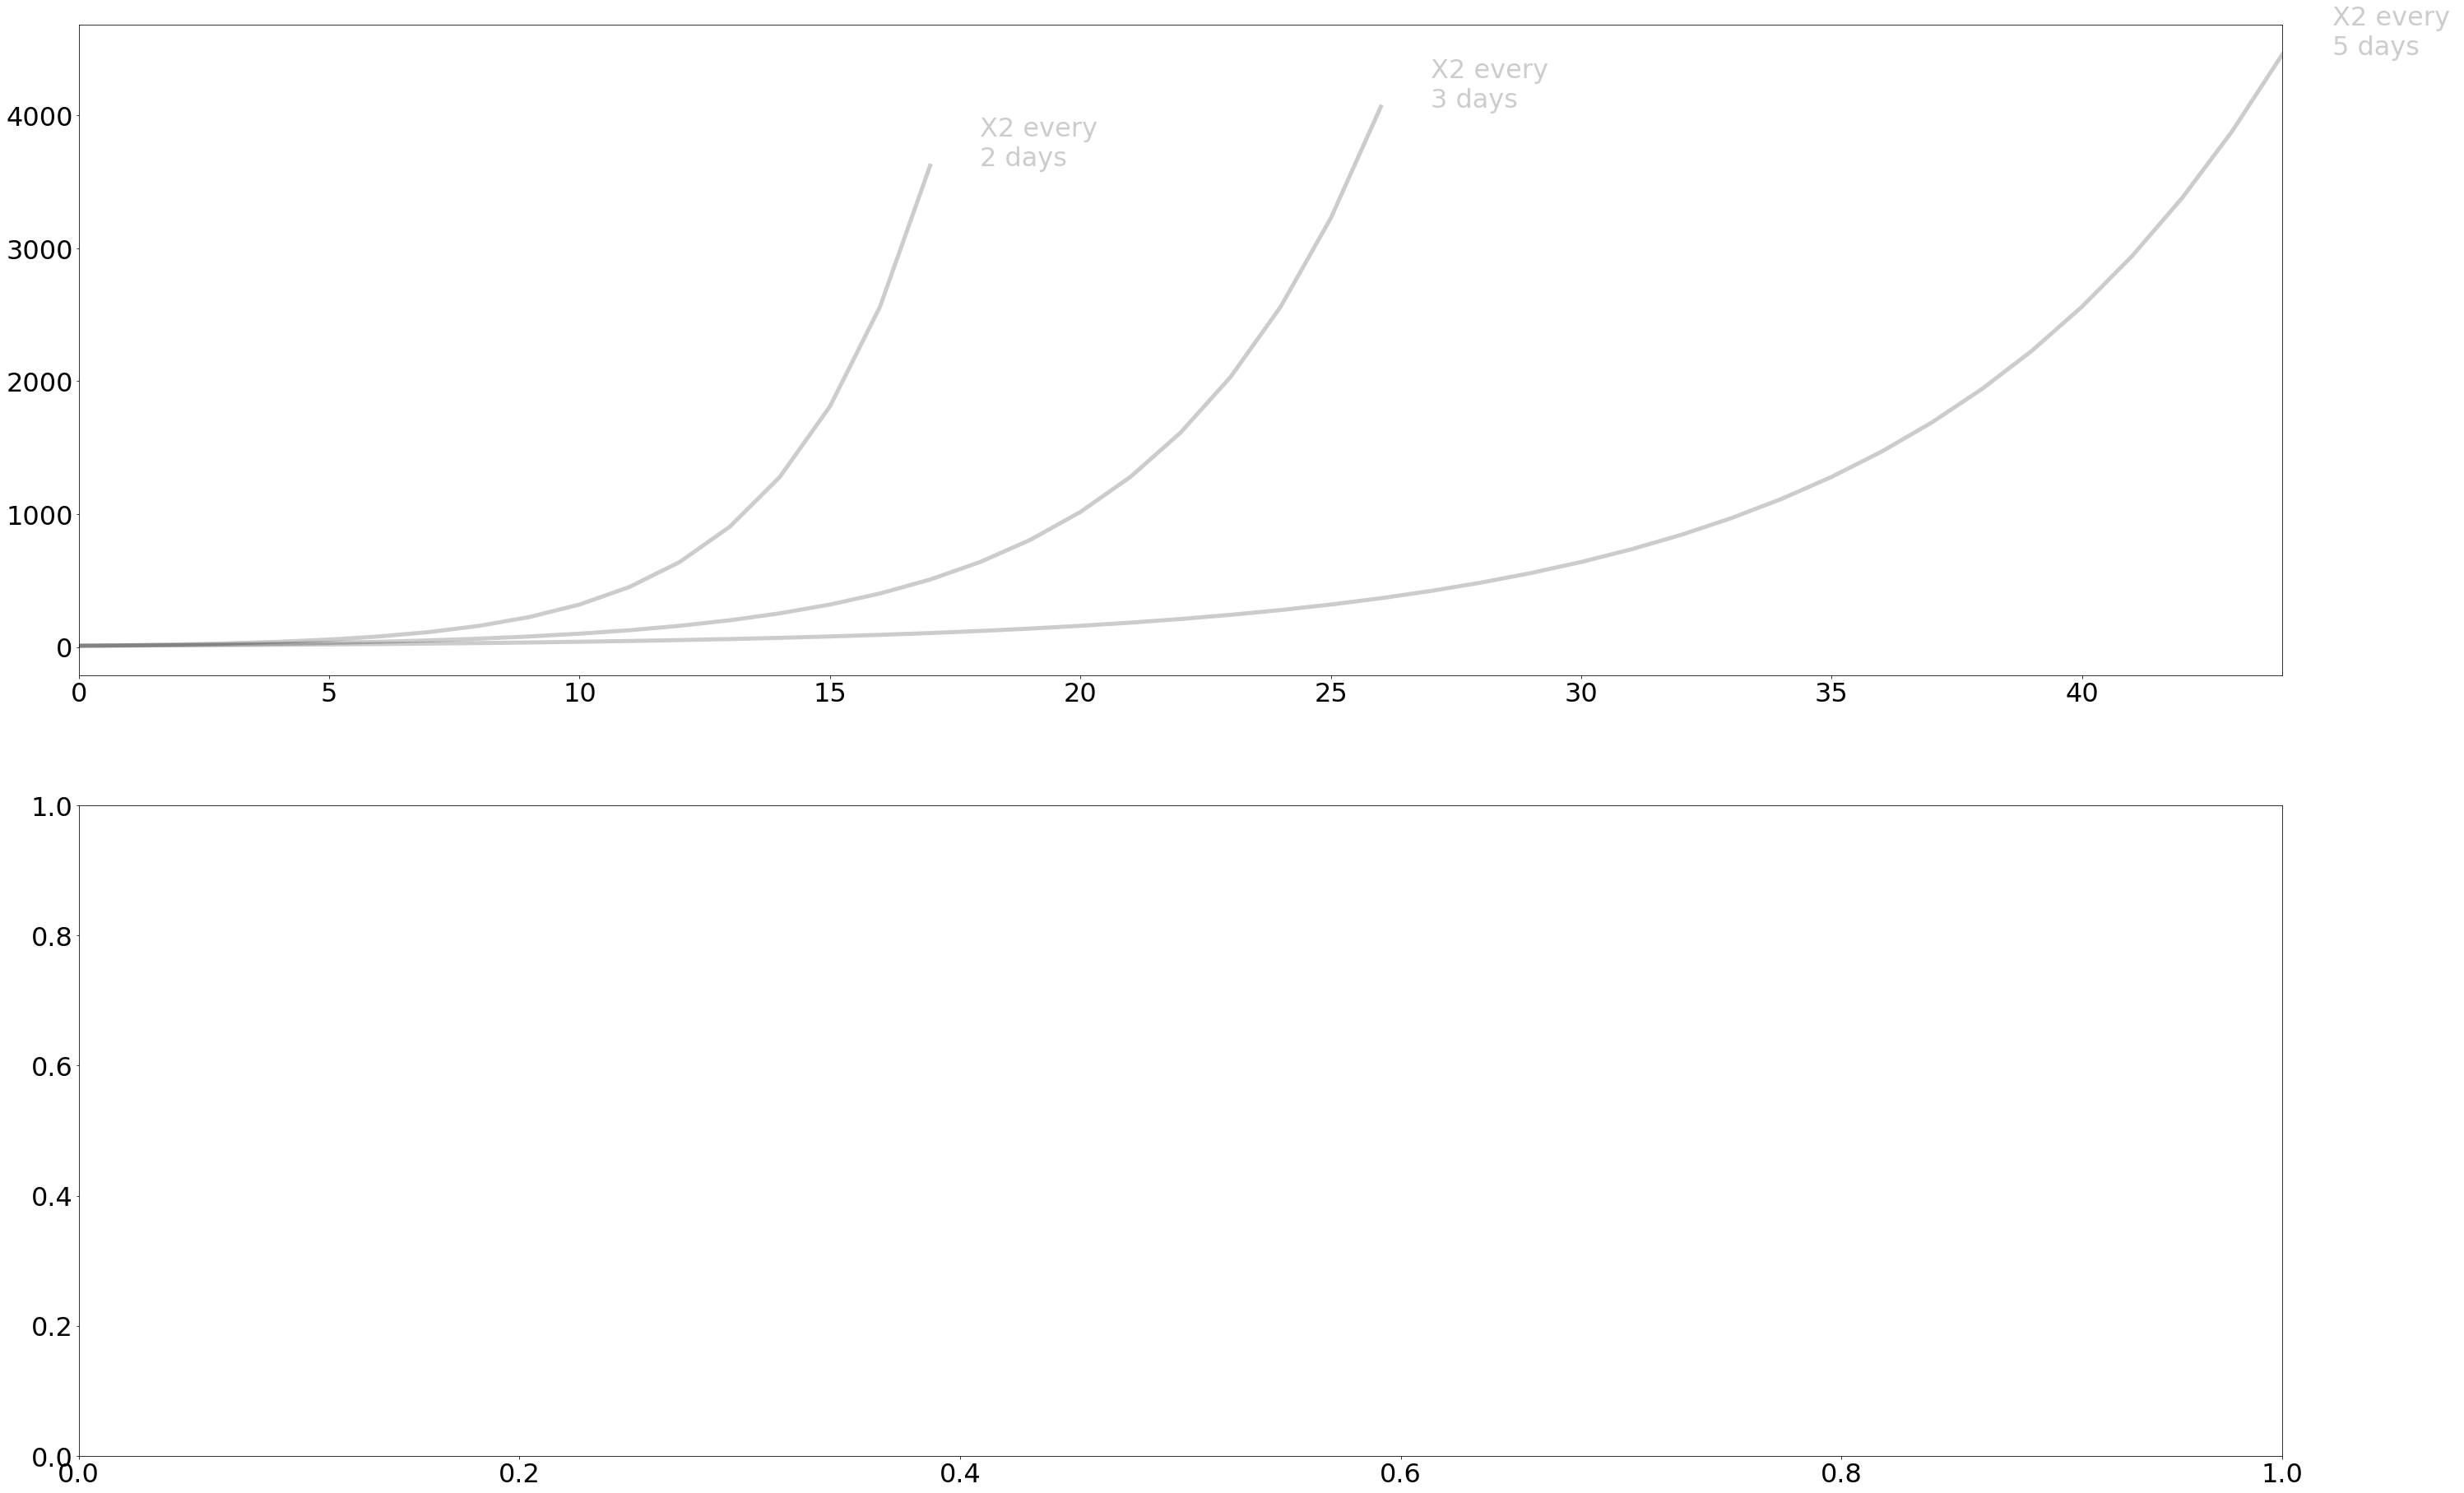

In [23]:
plt.rcParams['axes.xmargin'] = 0
plt.rcParams.update({'font.size': 32})
keys = ["Cases per Million", "Deaths per Million"]

lines= {}
colors = ["C" + str(i) for i in range(10)]
colors_dict = {}
pp = PdfPages("covidDataByState.pdf")
n_largest = 10


for daily in [True, False]:
    if not daily:
        for state_name, state in state_dict.items():
            state_fips = sorted(list(set(covid_data[covid_data["state_abr"] == state].index.get_level_values("fips_code").copy())))
            plot_zero_day_data(state_name, state, covid_data, county_zero_day_dict, 
                              day_zero_val, keys, "fips_code", state_fips, pp, 
                              n_largest, daily = daily)
        
    else:
        plot_zero_day_data("Upper Midwest", "Upper Midwest", state_data, state_zero_day_dict, 
                          day_zero_val, keys, "state", state_dict.keys(), pp,
                              bold_entities = ["IA", "MN", "NE", "ND","SD", "WI"],
                              daily = daily)

    
    
    
pp.close()

Output will be generated in the following format: 

<img src="https://github.com/jlcatonjr/COVID19/blob/main/Data/statePlots/Upper%20Midwest%20Daily%20Deaths%20per%20Million%20MA.png?raw=true" alt="U.S. Covid Rates" title="" />
<h3><center></center></h3>
<img src="https://github.com/jlcatonjr/COVID19/blob/main/Data/statePlots/ND%20Deaths%20per%20Million.png?raw=true" alt="New York Covid Levels" title="" />

If you would like to view the full set of output, go to the statePlots folder in the GitHub directory where this post is stored.

### Conclusion

Here we learned to organize COVID-19 data for the purpose of plotting. The result is that we created visualizations that convey two kinds of data - Cases and Deaths - in two different formats - levels and daily rates - for two different levels of analysis - states and counties. We have identified opportunity for improvements in efficiency along the way that may be useful to develop if we continue to repurpose this script. 

In the next post, we will plot data using dynamic map where color reflects the level of Cases per Million and Deaths per Million. These visualization will provide understanding of the nature of the spread that started to evidence itself in mid-March.